# Capstone Project - Final Assignment
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [1. Introduction](#introduction)
    * [1.1 Business Problem](#problema)
    * [1.2 Data](#data_)
    * [1.3 Methodology](#methodology)    
* [2. Data acquisition and cleaning](#data_ad)
    * [2.1 Data sources](#data_sources)
    * [2.2 Data cleaning](#data_cleaning)
    * [2.3 Feature selection](#feature_select)
* [3. Exploratory Data Analysis](#analysis)
    * [3.1 Venues by category (without normalization)](#venues)
    * [3.2 Venues by category (with normalization)](#venues_norm)
    * [3.3 Venues by category (with normalizationv2)](#venues_normv2)
* [4. Clustering](#clustering)
* [5. Results](#results)
    * [5.1 Discussion](#discussion)
* [6. Conclusions](#conclusions)

# 1. Introduction <a name="introduction"></a>

## 1.1 Business Problem <a name="problema"></a>

Santiago de Chile is a growing city with many opportunities and a great place to visit. But as any other capital, for tourists with little time it could be confusing and complicated to choose where to go and when to go in order to optimize their time.

Regarding to that problem, in this project we will try to create options as recommendations for tourists. The idea is to help them to take decisions in base to characteristics of group of neighborhoods.

With this info the tourists could have more interesting data regarding to the concentration of venues that it could be possible to found in each group of neighborhoods. In addition, as it could be possible to find similar neighborhoods, the tourists could choose more easily in base to other variables like as close as possible from their hostel.

We will use our data science powers to generate a few most promising neighborhoods based on these criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by tourists.

## 1.2 Data <a name="data_"></a>

Based on definition of the problem, factors that will influence our decision are:

* Venues of each neighborhood

* Category of venues

* Distance of neighborhood from city center

Following data sources will be needed to extract/generate the required information:

* Name of the best-known neighborhoods of Santiago, chile: those names will be obtained through scraping to Wikipedia.

* Geographical coordinates of each neighborhood: As there are not formal address to each neighborhood, the coordinates looking by names will be obtained using Google Maps API geocoding.

* Venues around each neighborhood will be obtained using Foursquare API.

* Categories of each venue will be obtained using Foursquare API.

##  1.3 Methodology <a name="methodology"></a>

In this project I will limit the analysis considering that each neighborhood has a radius of 200mts from its center point (initially the idea was to consider 300mts but in the analysis it was found that several neighborhoods overlapped).

In first step we have collected the required data scraping Wikipedia and complementing through api query to google maps. Once both requests were done, we will have the name of neighborhoods and their coordinates.

Second step is to integrate the data with foursquare data calling to their api. The first call should get data regarding to venues around each location(neighborhood) and the second call should get the data of categories that foursquare use to tag each venue. As there are a lot of categories available, the decision was to take the most grouped set of categories, getting in this case a top 10 of categories.

In third and final step we will focus in understanding the integrated data using boxplot and maps tools. After that we will create clusters (using k-means clustering) of neighborhoods that meet some basic requirements established before in the business problem and we will explain the difference between each cluster using the most representative categories of each clusters.

# 2. Data acquisition and cleaning <a name="data_ad"></a>

## 2.1 Data sources <a name="data_sources"></a>

### 2.1.1 Wikipedia 

Let's scrape the principal neighborhoods of Santiago (Capital of Chile).

In [1]:
# importing libraries
import requests # retrieve data
from bs4 import BeautifulSoup # retrieve data

In [51]:
url = 'https://es.wikipedia.org/wiki/Santiago_(comuna)'
custom_header = {'user-agent': 'customUserAgent'}
# making request
r = requests.get(url, headers=custom_header)
# preparing retrieval
soup = BeautifulSoup(r.content)
mylist = soup.find('div', attrs={"class": "columns"}).text.split("\n")
neigh_names = mylist[1:-1]
neigh_names 

['Barrio Balmaceda',
 'Barrio Bellas Artes',
 'Barrio Bogotá',
 'Barrio Brasil',
 'Barrio Cívico de Santiago',
 'Barrio Club Hípico',
 'Barrio Concha y Toro',
 'Barrio Copiapó',
 'Barrio Cummings',
 'Barrio Dieciocho',
 'Barrio Ejército',
 'Barrio Franklin',
 'Barrio Huemul',
 'Barrio Judicial',
 'Barrio La Bolsa',
 'Barrio Lastarria',
 'Barrio Mapocho',
 'Barrio Matta Sur',
 'Barrio Meiggs',
 'Barrio Panamá',
 'Barrio París-Londres',
 'Barrio Parque Almagro',
 'Barrio Parque Forestal',
 'Barrio Pedro Montt',
 'Barrio República',
 'Barrio San Borja',
 'Barrio San Diego',
 'Barrio San Eugenio',
 'Barrio San Isidro',
 'Barrio San Pablo',
 'Barrio San Vicente',
 'Barrio Santa Ana',
 'Barrio Santa Elena',
 'Barrio Santa Isabel',
 'Barrio Santa Rosa',
 'Barrio Sierra Bella',
 'Barrio Viel',
 'Barrio Yungay']

### 2.1.2 Google Maps 

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods.

In [59]:
google_api_key = ''
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

In [60]:
neig_name, neig_address, neig_latitude, neig_longitude= [], [], [], []
for neig in neigh_names:
    neighborhood_address = '{}, santiago, chile'.format(neig)
    neighborhood_coordinates = get_coordinates(google_api_key, neighborhood_address)
    if neighborhood_coordinates[0] != None:
        neig_address.append(neighborhood_address)
        neig_latitude.append(neighborhood_coordinates[0])
        neig_longitude.append(neighborhood_coordinates[1])
        neig_name.append(neig[7:])
    print(neighborhood_address, " - ", neighborhood_coordinates)

Barrio Balmaceda, santiago, chile  -  [-33.431778, -70.672386]
Barrio Bellas Artes, santiago, chile  -  [-33.43634960000001, -70.64360409999999]
Barrio Bogotá, santiago, chile  -  [-33.46379, -70.62938]
Barrio Brasil, santiago, chile  -  [-33.4390218, -70.66692909999999]
Barrio Cívico de Santiago, santiago, chile  -  [-33.4450427, -70.654051]
Barrio Club Hípico, santiago, chile  -  [-33.46342, -70.66709999999999]
Barrio Concha y Toro, santiago, chile  -  [-33.446018, -70.6663377]
Barrio Copiapó, santiago, chile  -  [-33.4544896, -70.6442671]
Barrio Cummings, santiago, chile  -  [-33.4488897, -70.6692655]
Barrio Dieciocho, santiago, chile  -  [-33.448326, -70.65823]
Barrio Ejército, santiago, chile  -  [-33.44909, -70.66244499999999]
Barrio Franklin, santiago, chile  -  [-33.4728669, -70.6420638]
Barrio Huemul, santiago, chile  -  [-33.474624, -70.65112979999999]
Barrio Judicial, santiago, chile  -  [-33.4488897, -70.6692655]
Barrio La Bolsa, santiago, chile  -  [-33.4424145, -70.651614

save the files to not make api requests again

In [61]:
files_to_save = [neig_name, neig_address, neig_latitude, neig_longitude]
files_name = ['neig_name', 'neig_address', 'neig_latitude', 'neig_longitude']
for index, file in enumerate(files_to_save):
    with open('{}.txt'.format(files_name[index]), 'w') as f:
        for item in file:
            f.write("%s\n" % item)

### 2.1.3 Foursquare 

#### 2.1.3.1 Top 50 venues

Get the top 50 venues per each neighborhood

In [62]:
import pandas as pd

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
Version="20180605"

def getVenues(name, latitude, longitude, radius=200, LIMIT=50):
    venues_list = []
    for name, lat, lng in zip(name, latitude, longitude):
        #print(name)
        
        #API URL request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, Version, lat, lng, radius, LIMIT)
      
        #get request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
    
        #return relevant information of each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        
        nearby_venues.columns = ["Neighborhood"," latitude","longitude",
                             "Venue","Venue Latitude","Venue Longitude","Venue Category"]
    return(nearby_venues)

In [63]:
df1 = getVenues(name = neig_name, 
                        latitude = neig_latitude,
                        longitude = neig_longitude)
df1.head(10)

,Neighborhood,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balmaceda,-33.431778,-70.672386,Pizzeria Los Reyes,-33.431720,-70.674015,Pizza Place
1,Bellas Artes,-33.436350,-70.643604,Barrio Bellas Artes,-33.436466,-70.644221,Neighborhood
2,Bellas Artes,-33.436350,-70.643604,La Casona Hostel,-33.437120,-70.644897,Hostel
3,Bellas Artes,-33.436350,-70.643604,Conversería de Julio,-33.437550,-70.642684,Latin American Restaurant
4,Bellas Artes,-33.436350,-70.643604,Anfiteatro Museo de Bellas Artes,-33.434814,-70.643806,Theater
5,Bellas Artes,-33.436350,-70.643604,Plop! Galería,-33.437329,-70.642196,Art Gallery
6,Bellas Artes,-33.436350,-70.643604,Ambar Wellness & Spa,-33.437004,-70.643425,Spa
7,Bellas Artes,-33.436350,-70.643604,Hotel Altiplanico Bellas Artes,-33.435538,-70.644635,Hotel
8,Bellas Artes,-33.436350,-70.643604,La Tienda Nacional,-33.437564,-70.642639,Miscellaneous Shop
9,Bellas Artes,-33.436350,-70.643604,Hostal de la Barra,-33.437150,-70.643428,Hostel


#### 2.1.3.2 Main categories

As Foursquare identifies 10 top level categories, I would like to categorize each venue with these categories 

1. Arts & Entertainment
2. College & University, 
3. Event
4. Food
5. Nightlife Spot
6. Outdoors & Recreation
7. Professional & Other Places
8. Residence
9. Shop & Service
10. Travel & Transport

* Do a request to the api to get all the categories (including parents and childrend) and add the main category to the dataframe

In [64]:
def categorize(CLIENT_ID, CLIENT_SECRET, Version):
    url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, Version)
    results2 = requests.get(url).json()

    response = results2['response']['categories']
    main_category = []
    for h in range(0, len(df1)):
        venue_cat = df1['Venue Category'].iloc[h]
        #print(venue_cat)
        for i in range(0, len(response)):
            level1_name = response[i]['name']
            if level1_name == venue_cat:
                main_category.append(level1_name)
            else:    
                for j in range(0, len(response[i]['categories'])):
                    level2_name = response[i]['categories'][j]['name']
                    if level2_name == venue_cat:
                        main_category.append(level1_name)
                    else:
                        for k in range(0, len(response[i]['categories'][j]['categories'])):
                            level3_name = response[i]['categories'][j]['categories'][k]['name']
                            if level3_name == venue_cat:
                                main_category.append(level1_name)
                            else:
                                for l in range(0, len(response[i]['categories'][j]['categories'][k]['categories'])):
                                    level4_name = response[i]['categories'][j]['categories'][k]['categories'][l]['name']
                                    if level4_name == venue_cat:
                                        main_category.append(level1_name)
                                    else:
                                        for m in range(0, len(response[i]['categories'][j]['categories'][k]['categories'][l]['categories'])):
                                            level5_name = response[i]['categories'][j]['categories'][k]['categories'][l]['categories'][m]['name']
                                            if level5_name == venue_cat:
                                                main_category.append(level1_name)

    print('Total of venues to categorize : {}'.format(len(df1['Venue Category'])))
    print('Total of venues found : {}'.format(len(main_category)))
    return main_category

In [65]:
df1['Top Category'] = categorize(CLIENT_ID, CLIENT_SECRET, Version)
df1.head(10)

Total of venues to categorize : 293
Total of venues found : 293


,Neighborhood,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Top Category
0,Balmaceda,-33.431778,-70.672386,Pizzeria Los Reyes,-33.431720,-70.674015,Pizza Place,Food
1,Bellas Artes,-33.436350,-70.643604,Barrio Bellas Artes,-33.436466,-70.644221,Neighborhood,Outdoors & Recreation
2,Bellas Artes,-33.436350,-70.643604,La Casona Hostel,-33.437120,-70.644897,Hostel,Travel & Transport
3,Bellas Artes,-33.436350,-70.643604,Conversería de Julio,-33.437550,-70.642684,Latin American Restaurant,Food
4,Bellas Artes,-33.436350,-70.643604,Anfiteatro Museo de Bellas Artes,-33.434814,-70.643806,Theater,Arts & Entertainment
5,Bellas Artes,-33.436350,-70.643604,Plop! Galería,-33.437329,-70.642196,Art Gallery,Arts & Entertainment
6,Bellas Artes,-33.436350,-70.643604,Ambar Wellness & Spa,-33.437004,-70.643425,Spa,Shop & Service
7,Bellas Artes,-33.436350,-70.643604,Hotel Altiplanico Bellas Artes,-33.435538,-70.644635,Hotel,Travel & Transport
8,Bellas Artes,-33.436350,-70.643604,La Tienda Nacional,-33.437564,-70.642639,Miscellaneous Shop,Shop & Service
9,Bellas Artes,-33.436350,-70.643604,Hostal de la Barra,-33.437150,-70.643428,Hostel,Travel & Transport


In [66]:
df1.tail(10)

,Neighborhood,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Top Category
283,Sierra Bella,-33.472260,-70.632984,calle sierra bella,-33.472462,-70.632944,Water Park,Arts & Entertainment
284,Sierra Bella,-33.472260,-70.632984,Tokiio Sushi,-33.472976,-70.632702,Sushi Restaurant,Food
285,Viel,-33.465534,-70.655560,Donde Secall,-33.464273,-70.655031,Deli / Bodega,Food
286,Viel,-33.465534,-70.655560,Case Chile,-33.464455,-70.653922,Mobile Phone Shop,Shop & Service
287,Yungay,-33.442911,-70.673123,Restaurant Polleria Jahaira,-33.444431,-70.672017,Peruvian Restaurant,Food
288,Yungay,-33.442911,-70.673123,Chama's,-33.444555,-70.673010,Pizza Place,Food
289,Yungay,-33.442911,-70.673123,Feria Libre Esperanza,-33.443204,-70.674397,Market,Shop & Service
290,Yungay,-33.442911,-70.673123,La Trova,-33.442888,-70.673183,Bar,Nightlife Spot
291,Yungay,-33.442911,-70.673123,Bar Popular,-33.442125,-70.673626,Restaurant,Food
292,Yungay,-33.442911,-70.673123,Estación Yungay,-33.442119,-70.673590,Breakfast Spot,Food


## 2.2 Data cleaning <a name="data_cleaning"></a>

Let's plot the coordinates using folium library

In [67]:
import folium
santiago_center_coordinates = [-33.4377818,-70.6519894]
map_stgo = folium.Map(location=santiago_center_coordinates, zoom_start=13)
folium.Marker(santiago_center_coordinates, popup='Plaza de Armas de Santiago - KM=0').add_to(map_stgo)
for lat, lon, neighborhood in zip(neig_latitude, neig_longitude, neig_name):
    label = "{}".format(neighborhood) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=6, color='red', fill=True, fill_color='blue', fill_opacity=1, popup=label).add_to(map_stgo)
    folium.Circle([lat, lon], radius=3, color='blue', fill=False).add_to(map_stgo)
map_stgo

### 2.2.1 Amending coordinates

Two neighborhoods didn't get the right coordinates from google maps api-request. <p>These values should be updated. 
The new values were found using google map - gui interface <p>
    <p> * 'San Pablo' (west side)    </p> 
    <p> * 'San Diego' just in the center      </p>

In [68]:
#update coordinates
new_coordinates1 = {'San Diego': [-33.45413, -70.64919999999999],'San Pablo': [-33.4345414,-70.6600266]}
for index, neighborhood in enumerate(neig_name):
    print(index, neighborhood, neig_latitude[index], neig_longitude[index])
    if neighborhood in ['San Diego', 'San Pablo']:
        neig_latitude[index] = new_coordinates1[neighborhood][0]
        neig_longitude[index] = new_coordinates1[neighborhood][1]
        print(index, neighborhood, neig_latitude[index], neig_longitude[index])

0 Balmaceda -33.431778 -70.672386
1 Bellas Artes -33.43634960000001 -70.64360409999999
2 Bogotá -33.46379 -70.62938
3 Brasil -33.4390218 -70.66692909999999
4 Cívico de Santiago -33.4450427 -70.654051
5 Club Hípico -33.46342 -70.66709999999999
6 Concha y Toro -33.446018 -70.6663377
7 Copiapó -33.4544896 -70.6442671
8 Cummings -33.4488897 -70.6692655
9 Dieciocho -33.448326 -70.65823
10 Ejército -33.44909 -70.66244499999999
11 Franklin -33.4728669 -70.6420638
12 Huemul -33.474624 -70.65112979999999
13 Judicial -33.4488897 -70.6692655
14 La Bolsa -33.4424145 -70.65161499999999
15 Lastarria -33.4378263 -70.639476
16 Mapocho -33.4488897 -70.6692655
17 Matta Sur -33.4627623 -70.6342324
18 Meiggs -33.451482 -70.6774673
19 Panamá -33.4580796 -70.62570629999999
20 París-Londres -33.4448446 -70.6484199
21 Parque Almagro -33.4521121 -70.6535998
22 Parque Forestal -33.4356565 -70.6412692
23 Pedro Montt -33.4732494 -70.65957879999999
24 República -33.4529256 -70.6686261
25 San Borja -33.4590693 -70.

### 2.2.2 Nearest neighborhood (less than 300 mts)

As we want to get venues from each neighborhood, we should check whether they overlap

In [69]:
map_stgo = folium.Map(location=santiago_center_coordinates, zoom_start=13)
folium.Marker(santiago_center_coordinates, popup='Plaza de Armas de Santiago - KM=0').add_to(map_stgo)
for lat, lon, neighborhood in zip(neig_latitude, neig_longitude, neig_name):
    label = "{}".format(neighborhood) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color='red', fill=True, fill_color='blue', fill_opacity=1, popup=label).add_to(map_stgo)
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_stgo)
map_stgo

As it seems like neighborhoods are not too big... let's see whether 200 mts could fit

In [70]:
map_stgo = folium.Map(location=santiago_center_coordinates, zoom_start=13)
folium.Marker(santiago_center_coordinates, popup='Plaza de Armas de Santiago - KM=0').add_to(map_stgo)
for lat, lon, neighborhood in zip(neig_latitude, neig_longitude, neig_name):
    label = "{}".format(neighborhood) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color='red', fill=True, fill_color='blue', fill_opacity=1, popup=label).add_to(map_stgo)
    folium.Circle([lat, lon], radius=200, color='blue', fill=False).add_to(map_stgo)
map_stgo

Ok, so we just need to amend 3 center points (northeast)

In [71]:
new_coordinates2 = {'Bellas Artes':[-33.43698960000001, -70.6440409999999],
                    'Lastarria': [-33.4392484,-70.640592],
                    'Parque Forestal': [-33.4356565, -70.6402192]}

for index, neighborhood in enumerate(neig_name):
    if neighborhood in ['Bellas Artes', 'Lastarria', 'Parque Forestal']:
        neig_latitude[index] = new_coordinates2[neighborhood][0]
        neig_longitude[index] = new_coordinates2[neighborhood][1]
        
map_stgo = folium.Map(location=santiago_center_coordinates, zoom_start=13)
folium.Marker(santiago_center_coordinates, popup='Plaza de Armas de Santiago - KM=0').add_to(map_stgo)
for lat, lon, neighborhood in zip(neig_latitude, neig_longitude, neig_name):
    label = "{}".format(neighborhood) 
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, color='red', fill=True, fill_color='blue', fill_opacity=1, popup=label).add_to(map_stgo)
    folium.Circle([lat, lon], radius=200, color='blue', fill=False).add_to(map_stgo)
map_stgo

In [75]:
# request again the venues for each point
df1 = getVenues(name = neig_name, 
                        latitude = neig_latitude,
                        longitude = neig_longitude)

df1['Top Category'] = categorize(CLIENT_ID, CLIENT_SECRET, Version)

Total of venues to categorize : 293
Total of venues found : 293


## 2.3 Feature selection <a name="feature_select"></a>

Let's count the venues response from foursquare

In [76]:
df2 = df1.groupby(['Neighborhood',' latitude', 'longitude','Top Category'])['Venue Category'].count().to_frame().reset_index()
df2

,Neighborhood,latitude,longitude,Top Category,Venue Category
0,Balmaceda,-33.431778,-70.672386,Food,1
1,Bellas Artes,-33.436990,-70.644041,Arts & Entertainment,3
2,Bellas Artes,-33.436990,-70.644041,Food,10
3,Bellas Artes,-33.436990,-70.644041,Outdoors & Recreation,3
4,Bellas Artes,-33.436990,-70.644041,Shop & Service,3
...,...,...,...,...,...
109,Viel,-33.465534,-70.655560,Food,1
110,Viel,-33.465534,-70.655560,Shop & Service,1
111,Yungay,-33.442911,-70.673123,Food,4
112,Yungay,-33.442911,-70.673123,Nightlife Spot,1


Formating the data to analyze

In [77]:
df3 = df2.pivot_table(index=['Neighborhood', ' latitude', 'longitude'], columns='Top Category', values='Venue Category').reset_index().rename_axis(None, axis=1)
df3 = df3.fillna(0)
df3.head(10)

,Neighborhood,latitude,longitude,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Balmaceda,-33.431778,-70.672386,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Bellas Artes,-33.436990,-70.644041,3.0,10.0,0.0,3.0,0.0,3.0,3.0
2,Bogotá,-33.463790,-70.629380,0.0,1.0,0.0,0.0,0.0,3.0,0.0
3,Brasil,-33.439022,-70.666929,0.0,11.0,5.0,1.0,0.0,1.0,0.0
4,Concha y Toro,-33.446018,-70.666338,0.0,8.0,4.0,2.0,2.0,2.0,1.0
5,Copiapó,-33.454490,-70.644267,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Cummings,-33.448890,-70.669265,0.0,4.0,2.0,1.0,1.0,0.0,1.0
7,Cívico de Santiago,-33.445043,-70.654051,3.0,8.0,0.0,5.0,0.0,1.0,0.0
8,Dieciocho,-33.448326,-70.658230,0.0,4.0,1.0,0.0,0.0,1.0,0.0
9,Ejército,-33.449090,-70.662445,0.0,4.0,1.0,0.0,0.0,0.0,0.0


# 3. Exploratory Data Analysis <a name="analysis"></a>

##  3.1 Venues by category (without normalization) <a name="venues"></a>

Check the distributions of venues by main categories without normalization (absolute values)

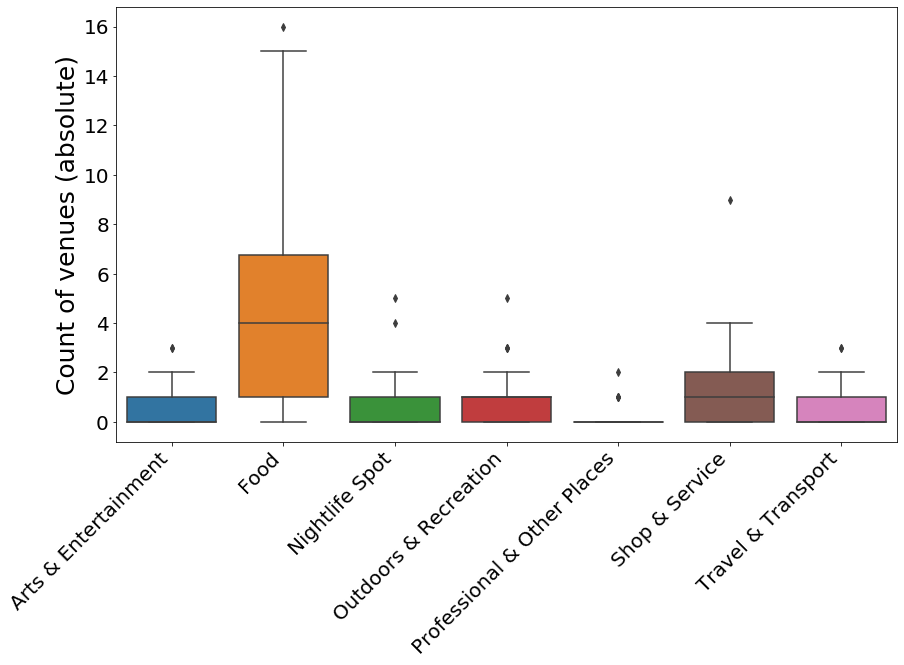

In [78]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

plt.figure(figsize=(14,8))
ax = sns.boxplot(data = df3.iloc[:,3:])
ax.set_ylabel('Count of venues (absolute)', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

Ok, so from 10 possible categories, there are only 7. The categories that were no found into the neighborhoods are: 
* College & University,
* Event
* Residence

It could be due to either of those are found mostly near the mencionated neighborhood but are not part of it.

In addition found more food venues in the capital makes sense.

The venues that content each category can be found here: https://developer.foursquare.com/docs/build-with-foursquare/categories

##  3.3 Venues by category (with normalization) <a name="venues_norm"></a>

Let's scale the data with a range of 0 to 1 per each category

In [79]:
from sklearn.preprocessing import MinMaxScaler
X = df3.values[:,3:]
scaled_dataset = MinMaxScaler().fit_transform(X)
df_scaled = pd.DataFrame(scaled_dataset)
df_scaled.columns = df3.columns[3:]
df_scaled.head()

,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.000000
1,1.0,0.6250,0.0,0.6,0.0,0.333333,1.000000
2,0.0,0.0625,0.0,0.0,0.0,0.333333,0.000000
3,0.0,0.6875,1.0,0.2,0.0,0.111111,0.000000
4,0.0,0.5000,0.8,0.4,1.0,0.222222,0.333333


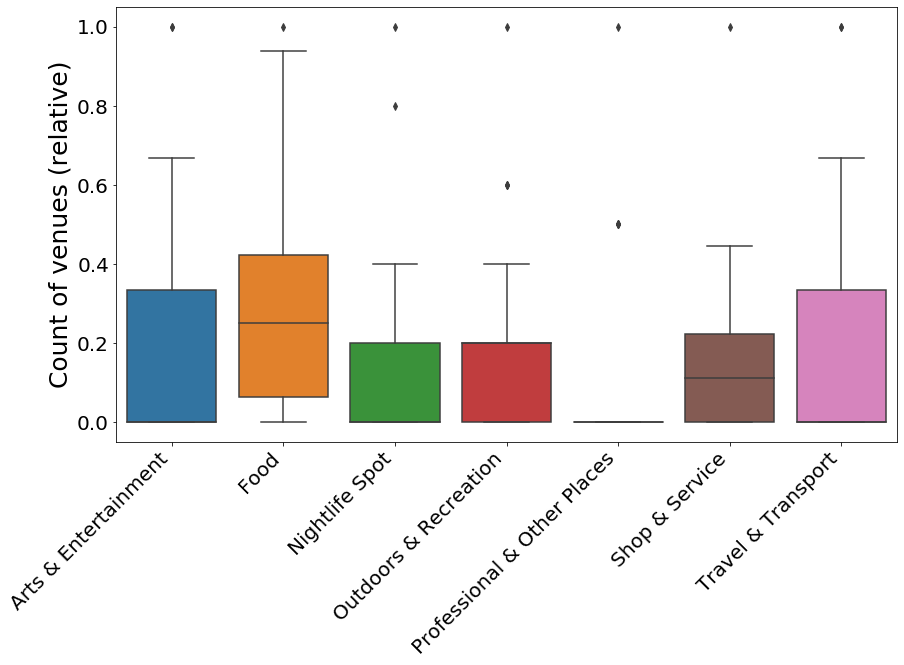

In [80]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(data = df_scaled)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [81]:
df_scaled.describe()

,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.196078,0.266544,0.147059,0.176471,0.088235,0.143791,0.225490
std,0.308332,0.265749,0.242756,0.234919,0.229313,0.190554,0.292678
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.250000,0.000000,0.200000,0.000000,0.111111,0.000000
75%,0.333333,0.421875,0.200000,0.200000,0.000000,0.222222,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3.4 Venues by category (with normalization v2) <a name="venues_normv2"></a>

Let's taking off the professional category (as outlier and poor data)

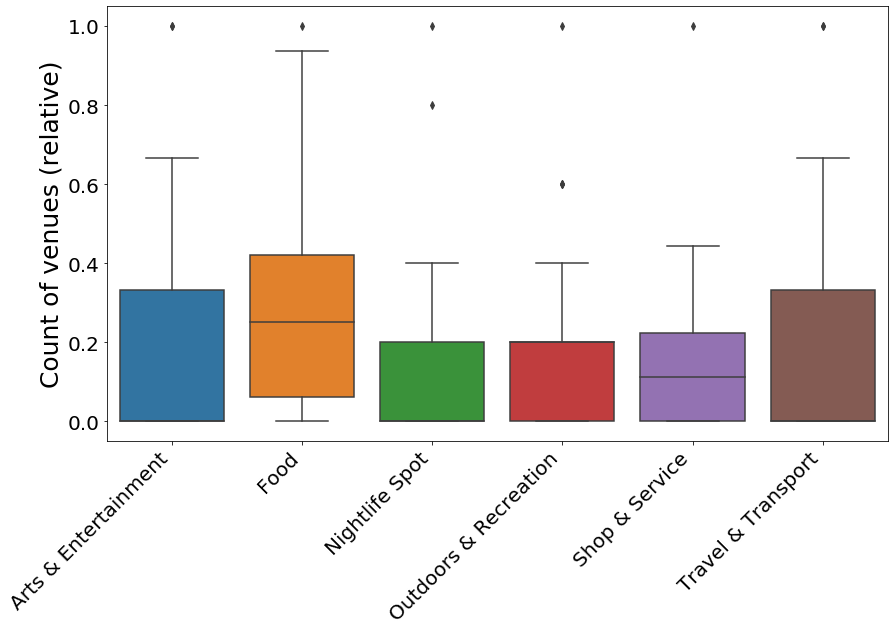

In [82]:
df_scaled = df_scaled[['Arts & Entertainment', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Shop & Service', 'Travel & Transport']]
plt.figure(figsize=(14,8))
ax = sns.boxplot(data = df_scaled)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

Now it looks more "normalized" and continue with the preference of food as the category most found in each neigborhood

# 4. Clustering <a name="clustering"></a>

I'll be using k-means clustering. These were preliminary results with different number of clusters:

* 2 clusters only show the diference between neighborhood with many venues vs neighborhood with low venues (ex. plaza).
* 3 clusters descompose the low venues neighborhood in 2 clusters
* 4 clusters more miscelanius clusters
* 5 and more clusters are difficult to interpret
* <b> For the final analysis we settle on 4 clusters <b>

In [90]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_scaled)
kmeans_labels = kmeans.labels_

# save clustered dataframe without normalización
df3_clustered = df3.copy()
df3_clustered['Cluster'] = kmeans_labels

# save clustered dataframe with normalización
df_scaled_clustered = df_scaled.copy()
df_scaled_clustered['Cluster'] = kmeans_labels

# 5. Results (k=4) <a name="results"></a>

Visualize the clusters with boxplots

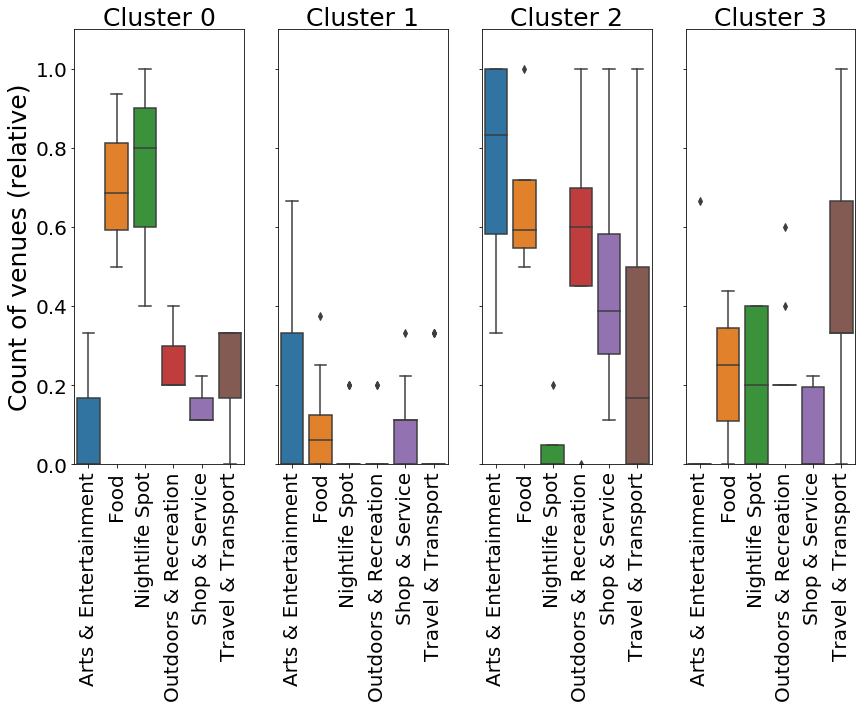

In [91]:
fig,axes= plt.subplots(1,kclusters,figsize=(14,8),sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(0, kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_scaled_clustered[df_scaled_clustered['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

Visualize the clusters with maps

In [92]:
map_stgo = folium.Map(location=santiago_center_coordinates, zoom_start=13)

#add markers
for i, area, lat, long, cluster in zip(df3_clustered.index,
                                         df3_clustered['Neighborhood'],
                                         df3_clustered[' latitude'],
                                         df3_clustered['longitude'],
                                         df3_clustered['Cluster']):   
    colors=['blue','green','red','magenta']
    #print(cluster)
    folium.CircleMarker(
        [lat,long],
        fill=True,
        fill_opacity=1,
        popup=folium.Popup(area, parse_html=True),
        radius=8,
        color=colors[cluster]
    ).add_to(map_stgo)
    #folium.Circle([lat, long], radius=200, color='black', fill=False).add_to(map_stgo)
    
    
map_stgo

In [86]:
map_stgo.save('neighborhoods_stgo.html')

#### Regarding to the boxplot and the map it could be possible to see 4 cluster with the following diferences

<b> Cluster #1  </b> : Neighborhoods as nice spot to go out for food and bars (nightlife).

<b> Cluster #2  </b> : Neighborhoods with low venues, their spots (few) are most related to arts & ei, food and shop and service.

<b> Cluster #3  </b> : Most diverse Neighborhoods, great for arts & ei, food, outdoor & recreation, shop & service and travel & transport.

<b> Cluster #4  </b> : Neighborhoods with travel and transport to any point of the city, 2nd place as a nightlife spot, some food and shop & service

## 5.1 Discussion <a name="discussion"></a>

From my point of view, there are two point that could change the results and analysis:

* Foursquare did not have too much success in Chile, therefore there are not enough venues assigned to each neighborhood. Anyway, as the assignment was asking to use foursquare-api and I wanted to explore my city I continue it despite of lack of some data.


* Using the same radius space for each neighborhood do not add precision to the analysis because each neighborhood have different distribution of it. With the boundaries of each neighborhood the analysis could improve (not available).


# 6. Conclusión <a name="conclusions"></a>

Despite of the difficulty found related to get info of Chile using foursquare api, the results make a lot of sense for me. I think that without doing a k test to find the best "k", just doing a manually k-testing from 2 to 5 k's, each result was easy to interpret. Finally, the object of this work is completed, So if you came to Santiago (Chile), you could use this work to see how many options do you have according to your interest, time and money.

The options are as follows:

Cluster #1 : Neighborhoods as nice spot to go out for food and bars (nightlife). <b> 3 Neighborhoods </b>


Cluster #2 : Neighborhoods with low venues, their spots (few) are most related to arts & ei, food and shop and service. <b> 17 Neighborhoods </b>

Cluster #3 : Most diverse Neighborhoods, great for arts & ei, food, outdoor & recreation, shop & service and travel & transport. <b> 4 Neighborhoods </b>

Cluster #4 : Neighborhoods with travel and transport to any point of the city, 2nd place as a nightlife spot, some food and shop & service. <b> 7 Neighborhoods </b>
